# 数据分析与机器学习综合案例 

## 数据清洗,特征工程,缺失值填补,分类.



## 导入标准库

In [1]:
import io, os, sys, types, time, datetime, math, random, requests, subprocess,io, tempfile

## 导入第三方库

In [113]:
# 数据处理
import numpy as np
import pandas as pd

# 数据可视化
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

# 特征选择和编码
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# 机器学习
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb   # 直接引用
from xgboost.sklearn import XGBClassifier   # sklearn风格的XGBoost



# 网格搜索、随机搜索
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 模型度量（分类）
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# 警告处理 
import warnings
warnings.filterwarnings('ignore')

# 在Jupyter上画图
%matplotlib inline

## 列出所有已安装的包
检查需要的包是否存在

In [3]:
conda_packages_list = io.BytesIO(subprocess.Popen(["conda", "list"], 
                                                         stdout=subprocess.PIPE).communicate()[0])
conda_packages_list = pd.read_csv(conda_packages_list, 
                                  names=['Package Name','Version','Python Version','Repo','Other'], 
                                  delim_whitespace=True, engine='python', skiprows=3)
conda_packages_list.head(5)

,Package Name,Version,Python Version,Repo,Other
0,_ipyw_jlab_nb_ext_conf,0.1.0,py36he6757f0_0,None,NaN
1,alabaster,0.7.10,py36hcd07829_0,None,NaN
2,anaconda,5.2.0,py36_3,None,NaN
3,anaconda-client,1.6.14,py36_0,None,NaN
4,anaconda-navigator,1.8.7,py36_0,None,NaN


## 目标

这个案例中，我们将使用美国人口普查收入数据集，根据人口普查数据预测个人收入是否超过每年50,000美元。

数据集地址: https://archive.ics.uci.edu/ml/datasets/adult

## 数据下载

让我们下载数据并将其保存到我们的本地目录中名为“dataset”的文件夹中。 注意：下载一次，然后将代码注释掉以便后续运行。

数据分为训练和测试数据集。 我们将两个进行联合数据分析，然后在运行算法之前再将它们分开。

In [4]:
# 下载
DATASET = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
)

def download_data(path='dataset', urls=DATASET):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path, name), 'wb+') as f:
            f.write(response.content)
        
        print('-----',str(urls.index(url)))

# download_data() # 第一次运行后注释掉

In [5]:
# 加载训练集和测试集
# 字段名
headers = ['age', 'workclass', 'fnlwgt', 
           'education', 'education-num', 
           'marital-status', 'occupation', 
           'relationship', 'race', 'sex', 
           'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 
           'predclass']
# 加载训练集
training_raw = pd.read_csv('G:/datas/adult.data', 
                       header=None, 
                       names=headers, 
                       sep=',\s', 
                       na_values=["?"], 
                       engine='python')
# 加载测试集
test_raw = pd.read_csv('G:/datas/adult.test', 
                      header=None, 
                      names=headers, 
                      sep=',\s', 
                      na_values=["?"], 
                      engine='python', 
                      skiprows=1)
# test_raw.shape :(16281, 15)
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         15318 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education-num     16281 non-null int64
marital-status    16281 non-null object
occupation        15315 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital-gain      16281 non-null int64
capital-loss      16281 non-null int64
hours-per-week    16281 non-null int64
native-country    16007 non-null object
predclass         16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [6]:
# 训练集和测试集加到一起做分析
dataset_raw = training_raw.append(test_raw)
dataset_raw.reset_index(inplace=True)
dataset_raw.drop('index',inplace=True,axis=1)

In [7]:
# DataFrame多大内存？
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("Bytes", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])
convert_size(dataset_raw.memory_usage().sum())

'5.59 MB'

## 单一变量数据分析
特征类型:
- **数字型:** 可计算.
- **标量型:** 任何包含类别或文本的特征.

In [8]:
# 显示所有数字型特征
dataset_raw.describe()


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [87]:
# 标量型特征
dataset_raw.describe(include='O')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,46043,48842,48842,46033,48842,48842,48842,47985
unique,5,8,5,6,6,5,2,8
top,Private,HS-grad,Married,Manual Labour,Husband,White,Male,United-States
freq,33906,15784,22416,15051,19716,41762,32650,43832


In [88]:
# 所有特征
dataset_raw.describe(include='all')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,predclass
count,48842.000000,46043,4.884200e+04,48842,48842.000000,48842,46033,48842,48842,48842,48842.000000,48842.000000,48842.000000,47985,48842.000000
unique,NaN,5,NaN,8,NaN,5,6,6,5,2,NaN,NaN,NaN,8,NaN
top,NaN,Private,NaN,HS-grad,NaN,Married,Manual Labour,Husband,White,Male,NaN,NaN,NaN,United-States,NaN
freq,NaN,33906,NaN,15784,NaN,22416,15051,19716,41762,32650,NaN,NaN,NaN,43832,NaN
mean,38.643585,NaN,1.896641e+05,NaN,10.078089,NaN,NaN,NaN,NaN,NaN,1079.067626,87.502314,40.422382,NaN,0.239282
std,13.710510,NaN,1.056040e+05,NaN,2.570973,NaN,NaN,NaN,NaN,NaN,7452.019058,403.004552,12.391444,NaN,0.426649
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,0.000000
25%,28.000000,NaN,1.175505e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,0.000000
50%,37.000000,NaN,1.781445e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,0.000000
75%,48.000000,NaN,2.376420e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,0.000000


In [10]:
# 查看前5行数据
dataset_raw.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,predclass
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


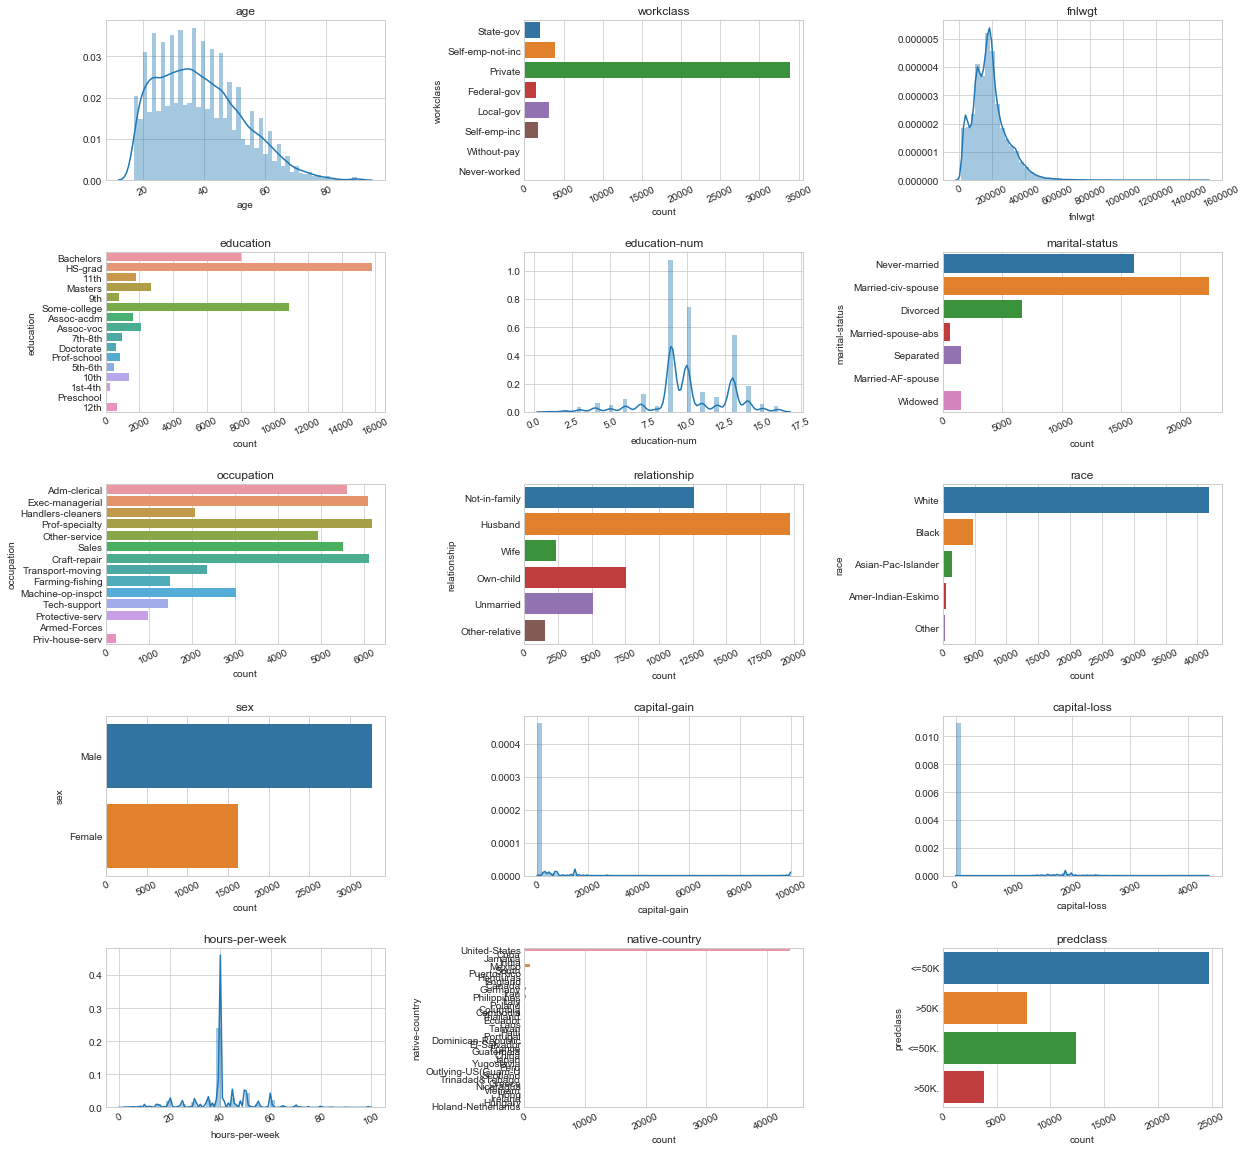

In [11]:
# 绘制每个特征的分布
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(dataset_raw, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

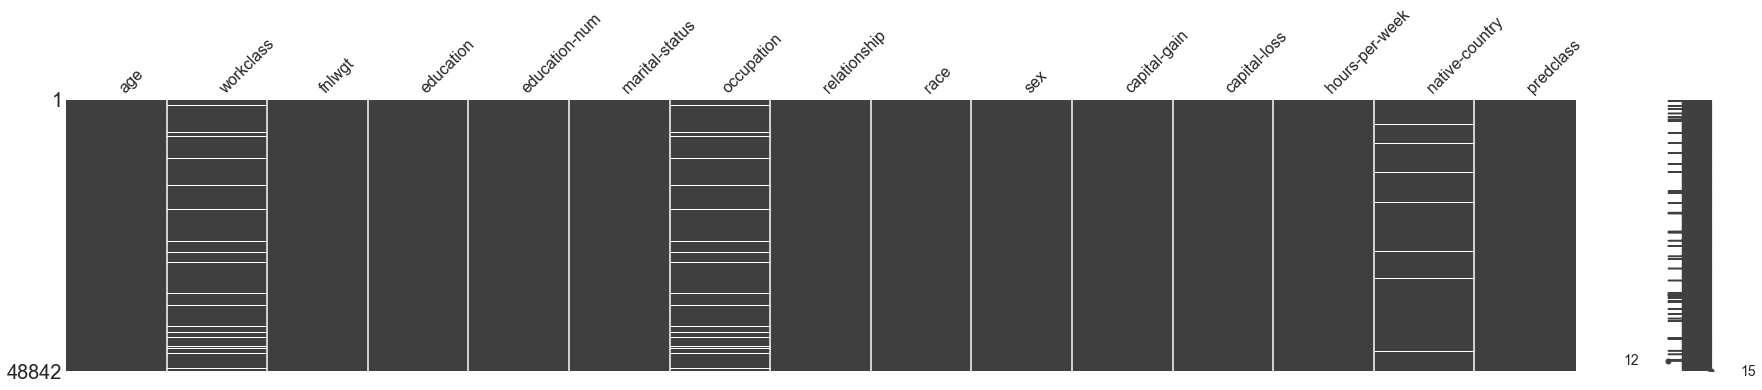

In [12]:
#查看缺失值个数
missingno.matrix(dataset_raw, figsize = (30,5))

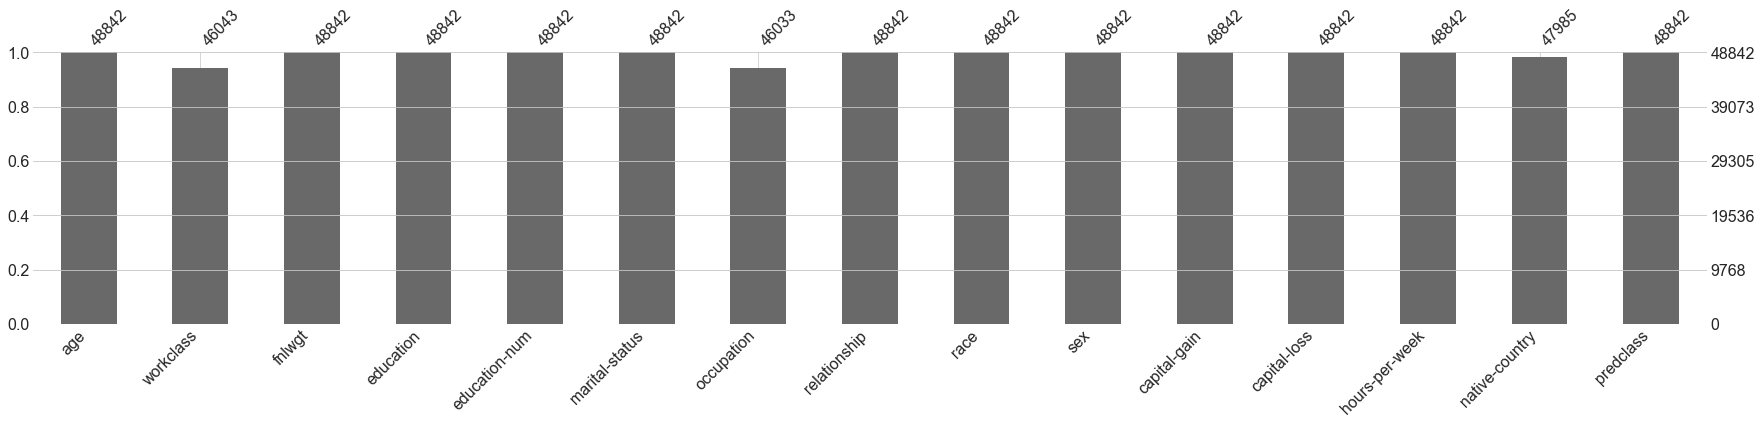

In [13]:
missingno.bar(dataset_raw, sort='ascending', figsize = (30,5))

# 特征清洗、特征工程、缺失值填补

**清洗:**
清洗什么？

- **缺失值:** 去除OR填补（方式？）.
- **特殊值:** N±Inf, NA and NaN.
- **奇异值:** 检测，是否去除？
- **不一致性:** 年龄<0，男的怀孕，etc.

**工程:**
方法:
- **分解:** 将2014-09-20T20：45：40Z转换为分类属性，如hour_of_the_day，part_of_day等
- **离散化:** 连续变量离散化，比较算法在连续数据和离散数据上的不同表现. 一些约定:

    - dataset_bin => 连续变量离散化后
    - dataset_con => 连续变量未离散化 

- **数值量级的转化:** 克-->千克，减少了数据细节可能会增加效率
- **特征交叉:** 字段衍生：新字段包好许多别的字段的特征（数字or标量）

**缺失值填补**
方式：
- **均值**
- **中位数** 
- **众数**
- **回归分析** 

In [14]:
# 创建新的DataFrame 
dataset_bin = pd.DataFrame() # 包含所有离散化后的值
dataset_con = pd.DataFrame() # 包含所有未离散化的值

### 我们一个个看特征

### 属性： Predclass

预测目标，转换为：0/1，年收入超过 $50K为1.

In [15]:
# 转换
dataset_raw.loc[dataset_raw['predclass'] == '>50K', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == '>50K.', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == '<=50K', 'predclass'] = 0
dataset_raw.loc[dataset_raw['predclass'] == '<=50K.', 'predclass'] = 0

dataset_bin['predclass'] = dataset_raw['predclass']
dataset_con['predclass'] = dataset_raw['predclass']

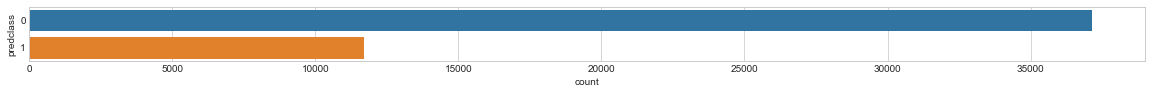

In [16]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,1)) 
sns.countplot(y="predclass", data=dataset_bin);

### 属性: Age

我们将使用Pandas Cut功能将数据分成大小相同的箱。原始数据放到dataset_con中。

In [17]:
#将连续值离散为若干个互不相交的子区间
dataset_bin['age'] = pd.cut(dataset_raw['age'], 10) # 离散化
dataset_con['age'] = dataset_raw['age'] # 未离散化



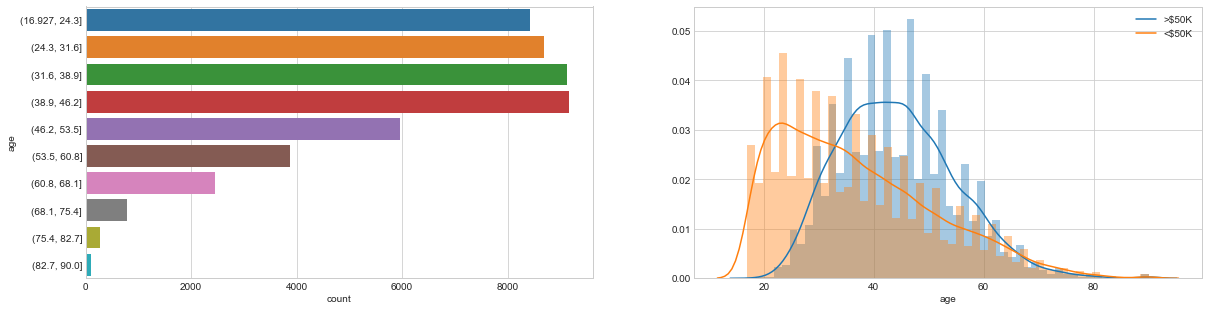

In [18]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 

plt.subplot(1, 2, 1)
sns.countplot(y="age", data=dataset_bin);  #  计数的直方图countplot

plt.subplot(1, 2, 2)
# 带趋势线的直方图
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age'], kde_kws={"label": ">$50K"});  # 直方图 + 核密度图
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age'], kde_kws={"label": "<$50K"});

### 属性: Workclass

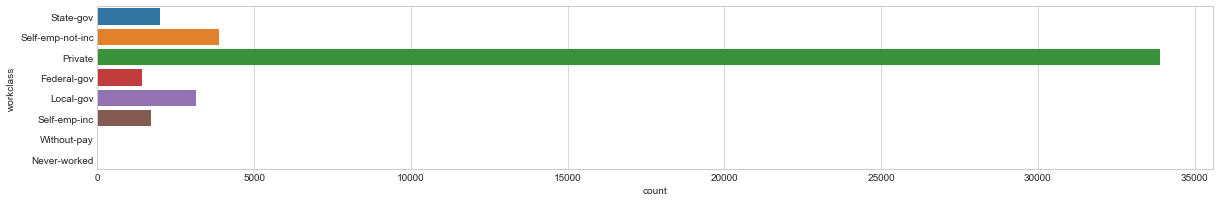

In [19]:
# 如何处理？
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,3)) 
sns.countplot(y="workclass", data=dataset_raw);

In [20]:
# 减少类别数目
dataset_raw.loc[dataset_raw['workclass'] == 'Without-pay', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Never-worked', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Federal-gov', 'workclass'] = 'Fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'State-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Local-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-not-inc', 'workclass'] = 'Self-emp'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-inc', 'workclass'] = 'Self-emp'

dataset_bin['workclass'] = dataset_raw['workclass']
dataset_con['workclass'] = dataset_raw['workclass']

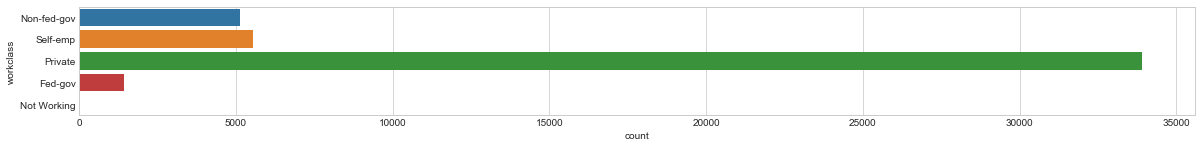

In [21]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,2)) 
sns.countplot(y="workclass", data=dataset_bin);

### 属性: Occupation

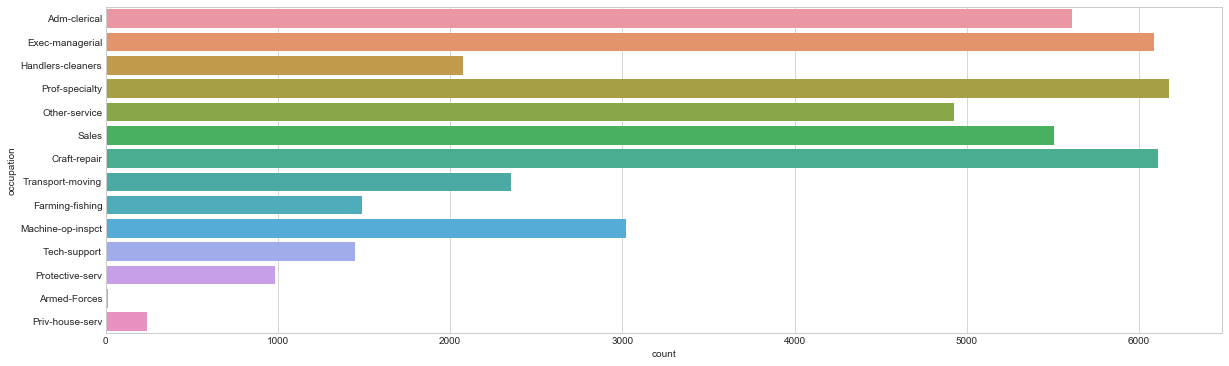

In [22]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,6)) 
sns.countplot(y="occupation", data=dataset_raw);

In [23]:
# 属性融合
dataset_raw.loc[dataset_raw['occupation'] == 'Adm-clerical', 'occupation'] = 'Admin'
dataset_raw.loc[dataset_raw['occupation'] == 'Armed-Forces', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Craft-repair', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Exec-managerial', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Farming-fishing', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Handlers-cleaners', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Machine-op-inspct', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Other-service', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Priv-house-serv', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Prof-specialty', 'occupation'] = 'Professional'
dataset_raw.loc[dataset_raw['occupation'] == 'Protective-serv', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Sales', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Tech-support', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Transport-moving', 'occupation'] = 'Manual Labour'

dataset_bin['occupation'] = dataset_raw['occupation']
dataset_con['occupation'] = dataset_raw['occupation']

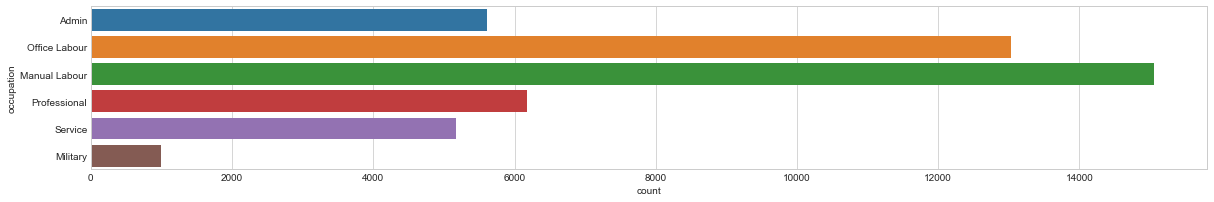

In [24]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3))
sns.countplot(y="occupation", data=dataset_bin);

### 属性: Native Country

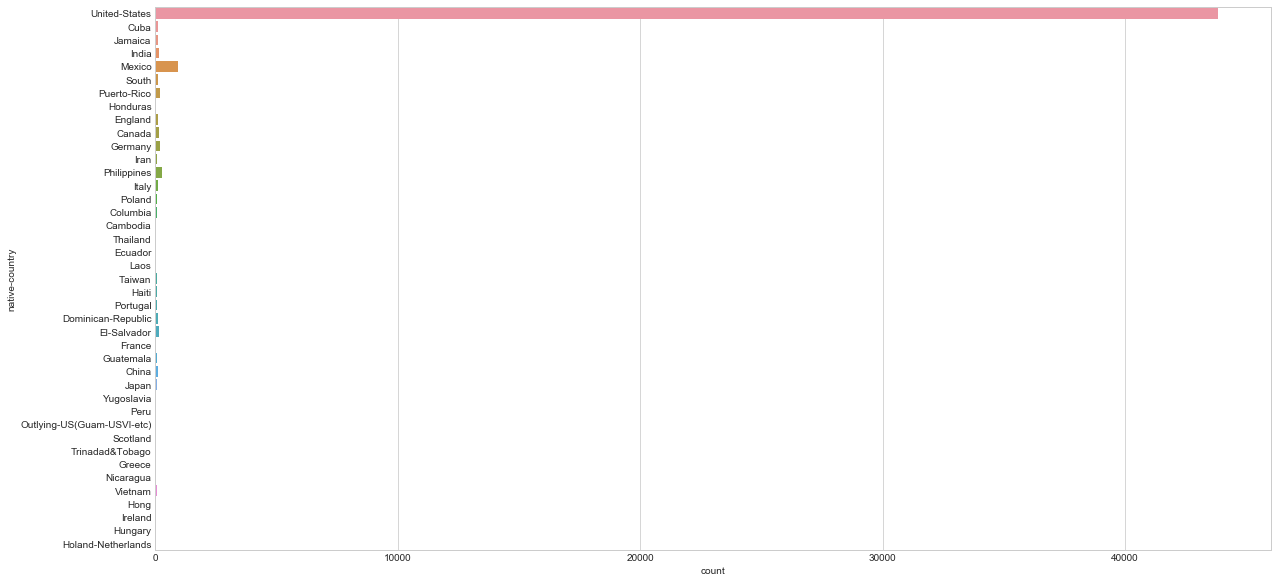

In [25]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,10)) 
sns.countplot(y="native-country", data=dataset_raw);

In [26]:
dataset_raw.loc[dataset_raw['native-country'] == 'Cambodia'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Canada'                      , 'native-country'] = 'British-Commonwealth'    
dataset_raw.loc[dataset_raw['native-country'] == 'China'                       , 'native-country'] = 'China'       
dataset_raw.loc[dataset_raw['native-country'] == 'Columbia'                    , 'native-country'] = 'South-America'    
dataset_raw.loc[dataset_raw['native-country'] == 'Cuba'                        , 'native-country'] = 'South-America'        
dataset_raw.loc[dataset_raw['native-country'] == 'Dominican-Republic'          , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Ecuador'                     , 'native-country'] = 'South-America'     
dataset_raw.loc[dataset_raw['native-country'] == 'El-Salvador'                 , 'native-country'] = 'South-America' 
dataset_raw.loc[dataset_raw['native-country'] == 'England'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'France'                      , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Germany'                     , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Greece'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Guatemala'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Haiti'                       , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Holand-Netherlands'          , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Honduras'                    , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Hong'                        , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Hungary'                     , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'India'                       , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Iran'                        , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Ireland'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Italy'                       , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Jamaica'                     , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Japan'                       , 'native-country'] = 'APAC'
dataset_raw.loc[dataset_raw['native-country'] == 'Laos'                        , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Mexico'                      , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Nicaragua'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Outlying-US(Guam-USVI-etc)'  , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Peru'                        , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Philippines'                 , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Poland'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Portugal'                    , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Puerto-Rico'                 , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Scotland'                    , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'South'                       , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Taiwan'                      , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Thailand'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Trinadad&Tobago'             , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'United-States'               , 'native-country'] = 'United-States'
dataset_raw.loc[dataset_raw['native-country'] == 'Vietnam'                     , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Yugoslavia'                  , 'native-country'] = 'Euro_Group_2'

dataset_bin['native-country'] = dataset_raw['native-country']
dataset_con['native-country'] = dataset_raw['native-country']

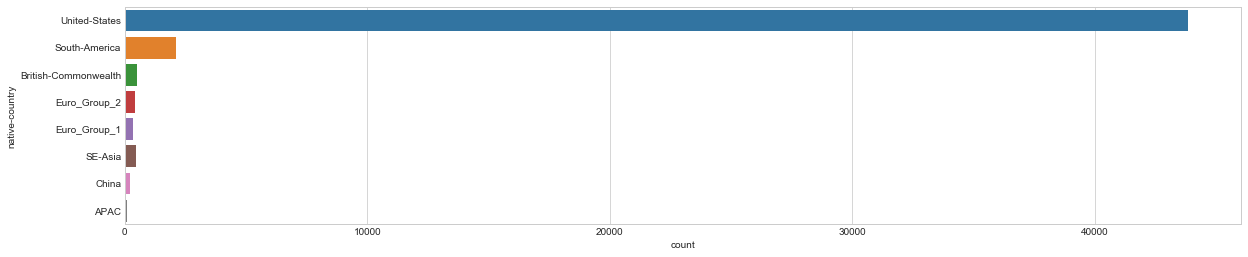

In [27]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="native-country", data=dataset_bin);

### 属性: Education

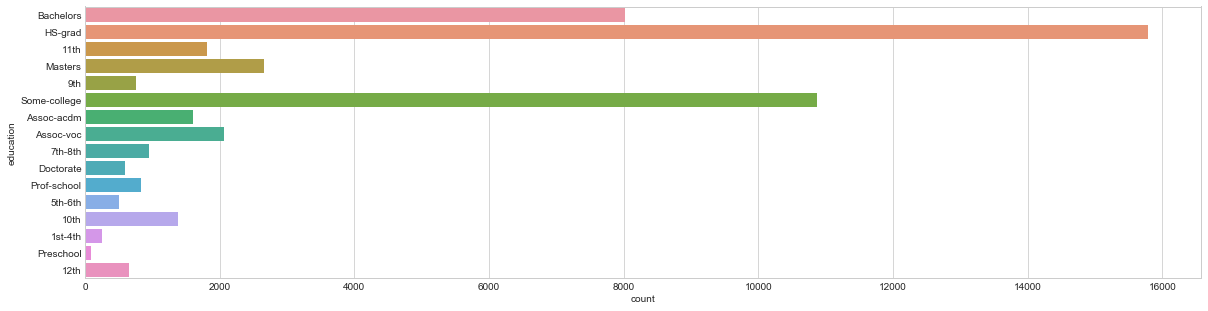

In [28]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
sns.countplot(y="education", data=dataset_raw);

In [29]:
dataset_raw.loc[dataset_raw['education'] == '10th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '11th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '12th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '1st-4th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '5th-6th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '7th-8th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '9th'           , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-acdm'    , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-voc'     , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Bachelors'     , 'education'] = 'Bachelors'
dataset_raw.loc[dataset_raw['education'] == 'Doctorate'     , 'education'] = 'Doctorate'
dataset_raw.loc[dataset_raw['education'] == 'HS-Grad'       , 'education'] = 'HS-Graduate'
dataset_raw.loc[dataset_raw['education'] == 'Masters'       , 'education'] = 'Masters'
dataset_raw.loc[dataset_raw['education'] == 'Preschool'     , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Prof-school'   , 'education'] = 'Professor'
dataset_raw.loc[dataset_raw['education'] == 'Some-college'  , 'education'] = 'HS-Graduate'

dataset_bin['education'] = dataset_raw['education']
dataset_con['education'] = dataset_raw['education']

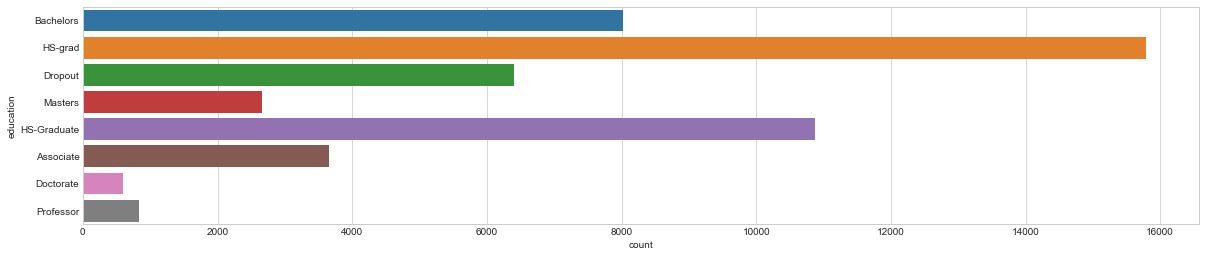

In [30]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="education", data=dataset_bin);

### 属性: Marital Status

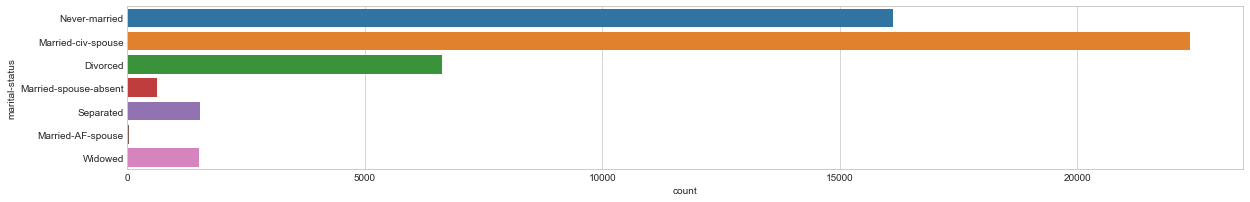

In [31]:
plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=dataset_raw);

In [32]:
dataset_raw.loc[dataset_raw['marital-status'] == 'Never-married'        , 'marital-status'] = 'Never-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-AF-spouse'    , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-civ-spouse'   , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-spouse-absent', 'marital-status'] = 'Not-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Separated'            , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Divorced'             , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Widowed'              , 'marital-status'] = 'Widowed'

dataset_bin['marital-status'] = dataset_raw['marital-status']
dataset_con['marital-status'] = dataset_raw['marital-status']

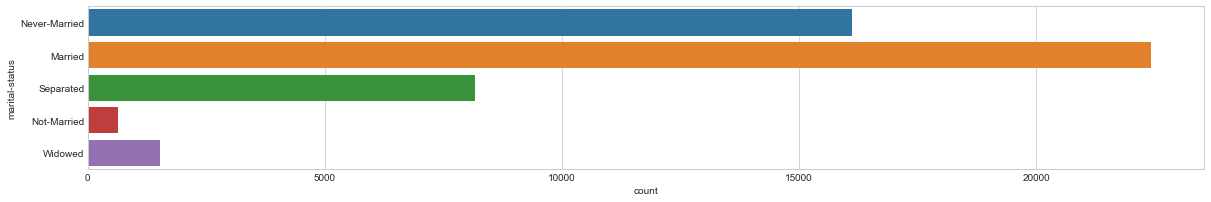

In [33]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=dataset_bin);

### 属性: Final Weight

In [34]:
# 体重分箱
dataset_bin['fnlwgt'] = pd.cut(dataset_raw['fnlwgt'], 10)
dataset_con['fnlwgt'] = dataset_raw['fnlwgt']

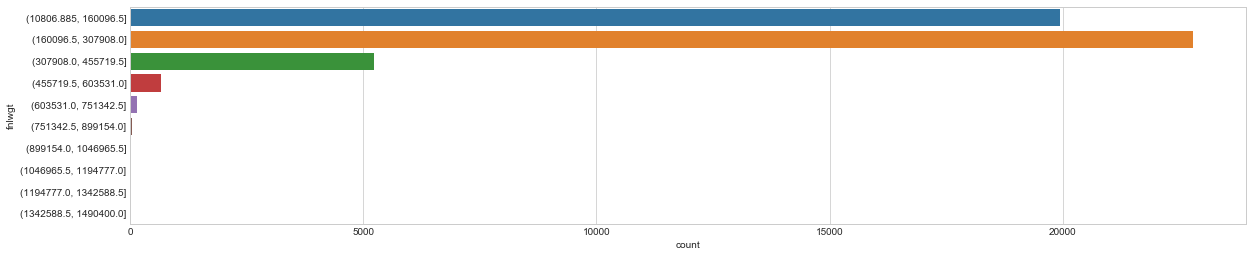

In [35]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="fnlwgt", data=dataset_bin);

### 属性: Education Number

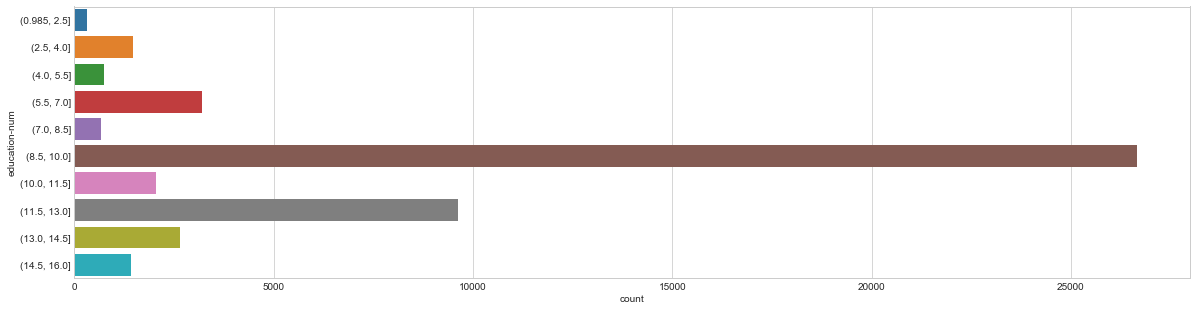

In [36]:
# 教育等级分箱
dataset_bin['education-num'] = pd.cut(dataset_raw['education-num'], 10)
dataset_con['education-num'] = dataset_raw['education-num']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="education-num", data=dataset_bin);

### Feature: Hours per Week

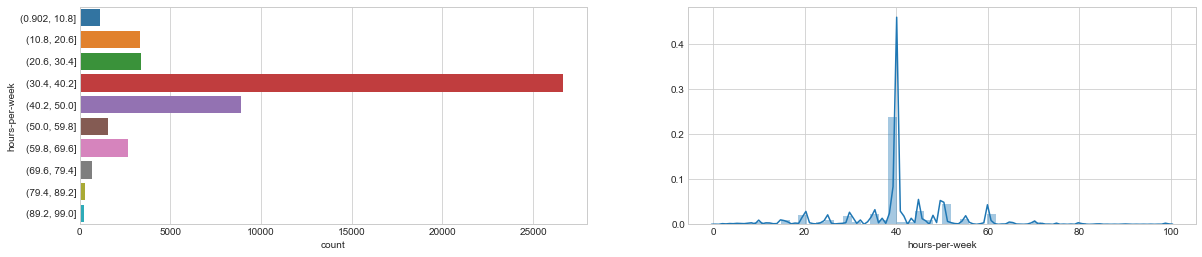

In [37]:
# 周工作时间（小时）分箱
dataset_bin['hours-per-week'] = pd.cut(dataset_raw['hours-per-week'], 10)
dataset_con['hours-per-week'] = dataset_raw['hours-per-week']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
plt.subplot(1, 2, 1)
# 分箱前
sns.countplot(y="hours-per-week", data=dataset_bin);
plt.subplot(1, 2, 2)
# 分箱后
sns.distplot(dataset_con['hours-per-week']);

In [38]:
dataset_bin


,predclass,age,workclass,occupation,native-country,education,marital-status,fnlwgt,education-num,hours-per-week
0,0,"(38.9, 46.2]",Non-fed-gov,Admin,United-States,Bachelors,Never-Married,"(10806.885, 160096.5]","(11.5, 13.0]","(30.4, 40.2]"
1,0,"(46.2, 53.5]",Self-emp,Office Labour,United-States,Bachelors,Married,"(10806.885, 160096.5]","(11.5, 13.0]","(10.8, 20.6]"
2,0,"(31.6, 38.9]",Private,Manual Labour,United-States,HS-grad,Separated,"(160096.5, 307908.0]","(8.5, 10.0]","(30.4, 40.2]"
3,0,"(46.2, 53.5]",Private,Manual Labour,United-States,Dropout,Married,"(160096.5, 307908.0]","(5.5, 7.0]","(30.4, 40.2]"
4,0,"(24.3, 31.6]",Private,Professional,South-America,Bachelors,Married,"(307908.0, 455719.5]","(11.5, 13.0]","(30.4, 40.2]"
5,0,"(31.6, 38.9]",Private,Office Labour,United-States,Masters,Married,"(160096.5, 307908.0]","(13.0, 14.5]","(30.4, 40.2]"
6,0,"(46.2, 53.5]",Private,Service,South-America,Dropout,Not-Married,"(160096.5, 307908.0]","(4.0, 5.5]","(10.8, 20.6]"
7,1,"(46.2, 53.5]",Self-emp,Office Labour,United-States,HS-grad,Married,"(160096.5, 307908.0]","(8.5, 10.0]","(40.2, 50.0]"
8,1,"(24.3, 31.6]",Private,Professional,United-States,Masters,Never-Married,"(10806.885, 160096.5]","(13.0, 14.5]","(40.2, 50.0]"
9,1,"(38.9, 46.2]",Private,Office Labour,United-States,Bachelors,Married,"(10806.885, 160096.5]","(11.5, 13.0]","(30.4, 40.2]"


In [39]:
+++++++++++++++++++++++

SyntaxError: invalid syntax (<ipython-input-39-6bee0d3ed08a>, line 1)

### 属性: Capital Gain

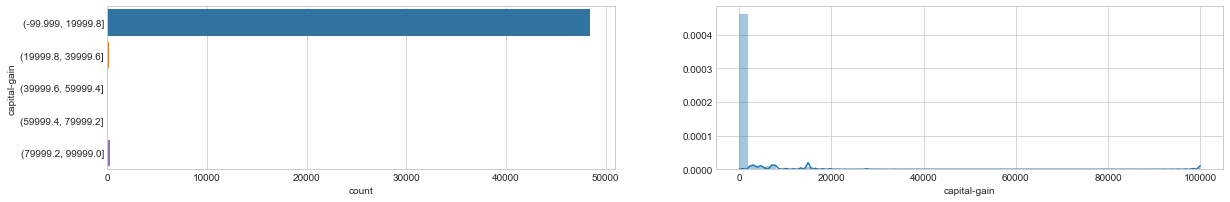

In [40]:
dataset_bin['capital-gain'] = pd.cut(dataset_raw['capital-gain'], 5)
dataset_con['capital-gain'] = dataset_raw['capital-gain']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-gain", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-gain']);

### 属性: Capital Loss

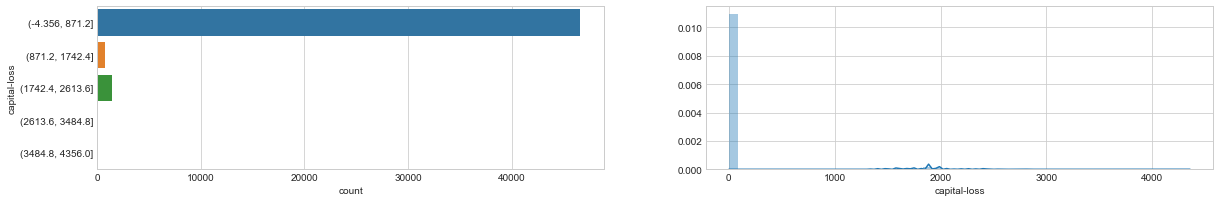

In [41]:
dataset_bin['capital-loss'] = pd.cut(dataset_raw['capital-loss'], 5)
dataset_con['capital-loss'] = dataset_raw['capital-loss']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-loss", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-loss']);

### 属性: Race, Sex, Relationship

In [42]:
# 无需处理
dataset_con['sex'] = dataset_bin['sex'] = dataset_raw['sex']
dataset_con['race'] = dataset_bin['race'] = dataset_raw['race']
dataset_con['relationship'] = dataset_bin['relationship'] = dataset_raw['relationship']

## 属性衍生: Age + Hours Per Week

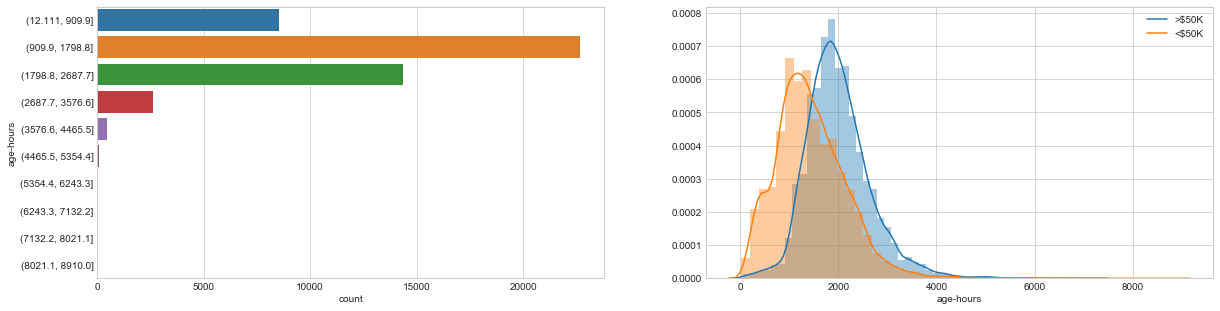

In [43]:
# 衍生
dataset_con['age-hours'] = dataset_con['age'] * dataset_con['hours-per-week']

dataset_bin['age-hours'] = pd.cut(dataset_con['age-hours'], 10)
dataset_con['age-hours'] = dataset_con['age-hours']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age-hours", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age-hours'], kde_kws={"label": ">$50K"});
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age-hours'], kde_kws={"label": "<$50K"});

In [89]:
dataset_con['sex']

0          Male
1          Male
2          Male
3          Male
4        Female
5        Female
6        Female
7          Male
8        Female
9          Male
10         Male
11         Male
12       Female
13         Male
14         Male
15         Male
16         Male
17         Male
18         Male
19       Female
20         Male
21       Female
22         Male
23         Male
24       Female
25         Male
26         Male
27         Male
28         Male
29         Male
          ...  
48812      Male
48813      Male
48814    Female
48815      Male
48816      Male
48817      Male
48818    Female
48819      Male
48820    Female
48821    Female
48822      Male
48823      Male
48824      Male
48825      Male
48826    Female
48827    Female
48828    Female
48829      Male
48830      Male
48831      Male
48832      Male
48833      Male
48834    Female
48835      Male
48836      Male
48837    Female
48838      Male
48839      Male
48840      Male
48841      Male
Name: sex, Length: 48842

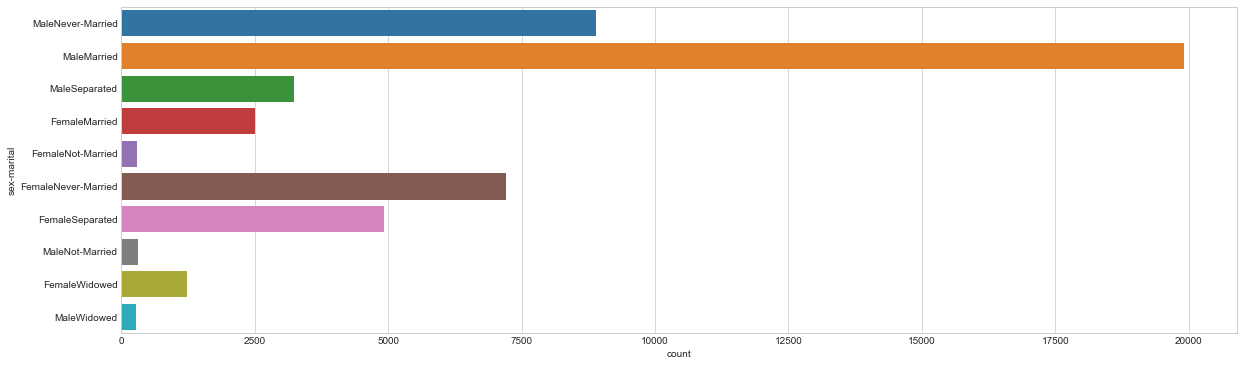

In [44]:
# 标量衍生
dataset_bin['sex-marital'] = dataset_con['sex-marital'] = dataset_con['sex'] + dataset_con['marital-status']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,6)) 
sns.countplot(y="sex-marital", data=dataset_bin);
# dataset_con['marital-status'].describe(include="O")


## 属性编码

why?
* 机器学习算法接收的是数字型变量。
* 把字符型编码为数字型的过程叫做编码
* 我们用到的：
    * 1.One-Hot 
    * 2.Label encoding.

In [45]:
# 所有变量进行One-Hot编码（离散）
one_hot_cols = dataset_bin.columns.tolist()
one_hot_cols.remove('predclass')
# One-Hot编码
dataset_bin_enc = pd.get_dummies(dataset_bin, columns=one_hot_cols)

dataset_bin_enc.head()

,predclass,"age_(16.927, 24.3]","age_(24.3, 31.6]","age_(31.6, 38.9]","age_(38.9, 46.2]","age_(46.2, 53.5]","age_(53.5, 60.8]","age_(60.8, 68.1]","age_(68.1, 75.4]","age_(75.4, 82.7]",...,sex-marital_FemaleMarried,sex-marital_FemaleNever-Married,sex-marital_FemaleNot-Married,sex-marital_FemaleSeparated,sex-marital_FemaleWidowed,sex-marital_MaleMarried,sex-marital_MaleNever-Married,sex-marital_MaleNot-Married,sex-marital_MaleSeparated,sex-marital_MaleWidowed
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [46]:
# 转换为连续型数字变量
encoder = LabelEncoder()
# print(dataset_con['workclass'])
dataset_con = dataset_con.astype(str)
dataset_con_enc = dataset_con.apply(encoder.fit_transform)

dataset_con_enc.head()

,predclass,age,workclass,occupation,native-country,education,marital-status,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,sex,race,relationship,age-hours,sex-marital
0,0,22,1,0,7,1,1,26905,4,34,35,0,1,4,1,252,6
1,0,33,4,3,7,1,0,27243,4,4,0,0,1,4,0,1268,5
2,0,21,3,1,7,5,3,13364,15,34,0,0,1,4,1,237,8
3,0,36,3,1,7,3,0,15068,13,34,0,0,1,2,0,481,5
4,0,11,3,4,6,1,0,21239,4,34,0,0,0,2,5,60,0


## 属性降维/选择（做减法）

原因：正确、效率。

- **降维:**
    - **Principal Component Analysis (PCA)** 
    - **Singular Value Decomposition (SVD)** 

- **选择（重要性）:**
    - **过滤:** 过滤方法仅根据一般度量标准选择要素，例如与要预测的变量的相关性。 过滤方法抑制最不感兴趣的变量。其他变量将是用于分类或预测数据的分类或回归模型的一部分。 这些方法在计算时间方面特别有效，并且对过度拟合具有鲁棒性。
    - **包装:** 包装方法评估变量子集，与过滤器方法不同，它允许检测变量之间可能的相互作用。 这些方法的两个主要缺点是：1.当观测数量不足时，过度拟合风险增加；2.变量数量很大时的显着计算时间。
    - **嵌入式:** 嵌入式方法试图结合两种先前方法的优点。 学习算法利用其自己的变量选择过程并同时执行特征选择和分类。

### 属性相关性

相关性衡量两个随机变量一起变化的程度。 
期望：属性应该彼此不相关，并且与我们试图预测的目标高度相关。

In [47]:
dataset_bin_enc.corr().shape

(116, 116)

In [48]:
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True   ##triu_indices_from  ##返回arr的上三角的索引。
mask


array([[ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True]])

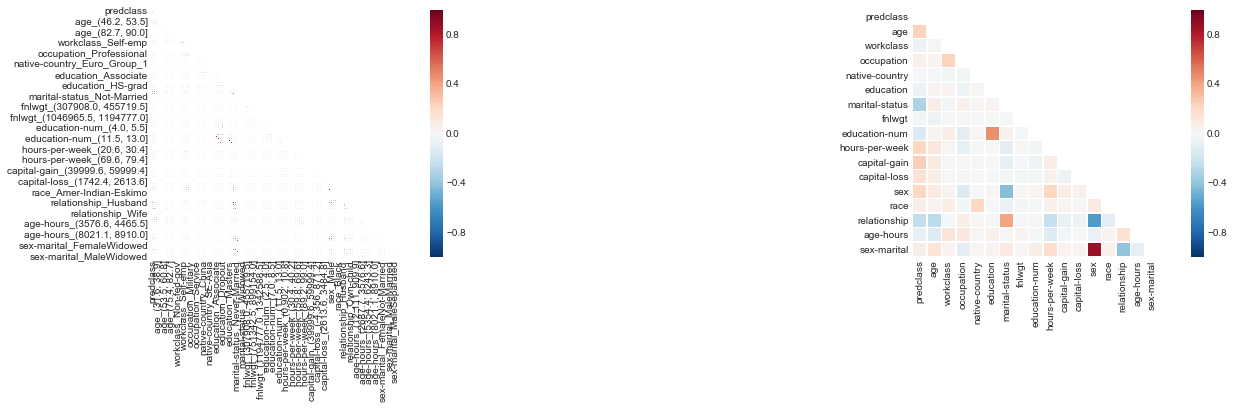

In [49]:
# 绘制两个数据集的关系图.
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 

plt.subplot(2, 2, 1)
# 关系热力图
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_bin_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

plt.subplot(2, 2, 2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True              ##返回arr的上三角的索引。
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);



### Feature Importance

随机森林

In [50]:
dataset_con_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 17 columns):
predclass         48842 non-null int64
age               48842 non-null int64
workclass         48842 non-null int64
occupation        48842 non-null int64
native-country    48842 non-null int64
education         48842 non-null int64
marital-status    48842 non-null int64
fnlwgt            48842 non-null int64
education-num     48842 non-null int64
hours-per-week    48842 non-null int64
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
sex               48842 non-null int64
race              48842 non-null int64
relationship      48842 non-null int64
age-hours         48842 non-null int64
sex-marital       48842 non-null int64
dtypes: int64(17)
memory usage: 6.3 MB


,Importance
age,0.119844
workclass,0.031662
occupation,0.056518
native-country,0.016413
education,0.058180
marital-status,0.115663
fnlwgt,0.178573
education-num,0.056285
hours-per-week,0.060229
capital-gain,0.076437


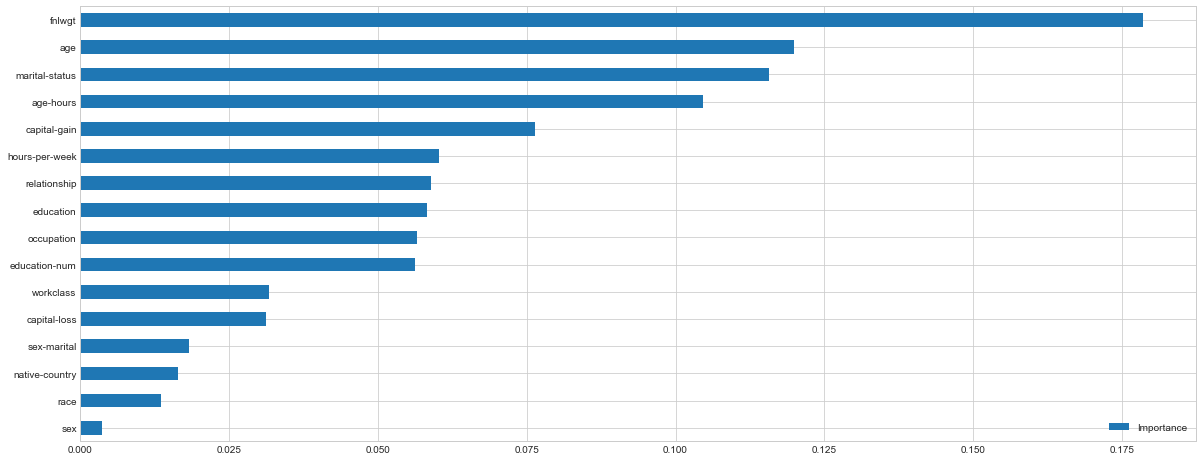

In [51]:
# 使用随机森林算法去查看属性重要性
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('predclass', axis=1), dataset_con_enc['predclass'])

plt.style.use('seaborn-whitegrid')
#随机森林算法（RandomForest）的输出有一个变量是 feature_importances_ ，翻译过来是 特征重要性
importance = clf.feature_importances_
importance
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('predclass', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));
importance

### PCA

In [52]:
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('predclass', axis=1))
X

array([[-0.45679451, -0.46508752, -0.47916144, ..., -0.08171863,
        -0.26615442, -0.07661195],
       [-0.45679451, -0.46508752, -0.47916144, ..., -0.08171863,
        -0.26615442, -0.07661195],
       [-0.45679451, -0.46508752,  2.08697927, ..., -0.08171863,
         3.75721734, -0.07661195],
       ...,
       [-0.45679451, -0.46508752,  2.08697927, ..., -0.08171863,
        -0.26615442, -0.07661195],
       [-0.45679451, -0.46508752, -0.47916144, ..., -0.08171863,
         3.75721734, -0.07661195],
       [-0.45679451, -0.46508752,  2.08697927, ..., -0.08171863,
        -0.26615442, -0.07661195]])

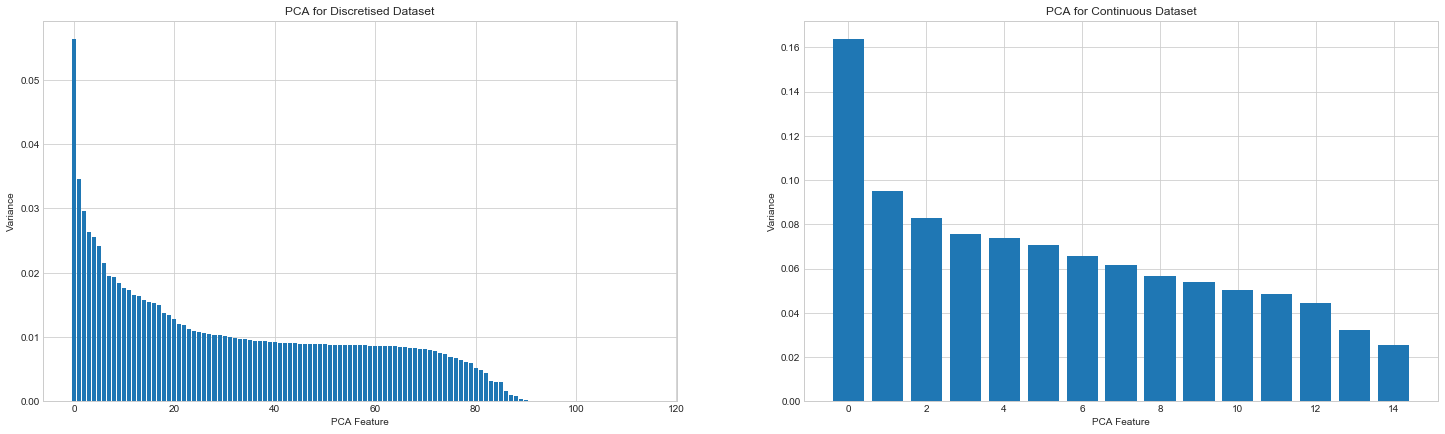

In [53]:
# 计算PCA并绘制方差
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('predclass', axis=1))
pca1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
fit1 = pca1.fit(X)

std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
fit2 = pca2.fit(X)

# 绘制每个属性的方差
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25,7)) 

plt.subplot(1, 2, 1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretised Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

plt.subplot(1, 2, 2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continuous Dataset')
plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_);

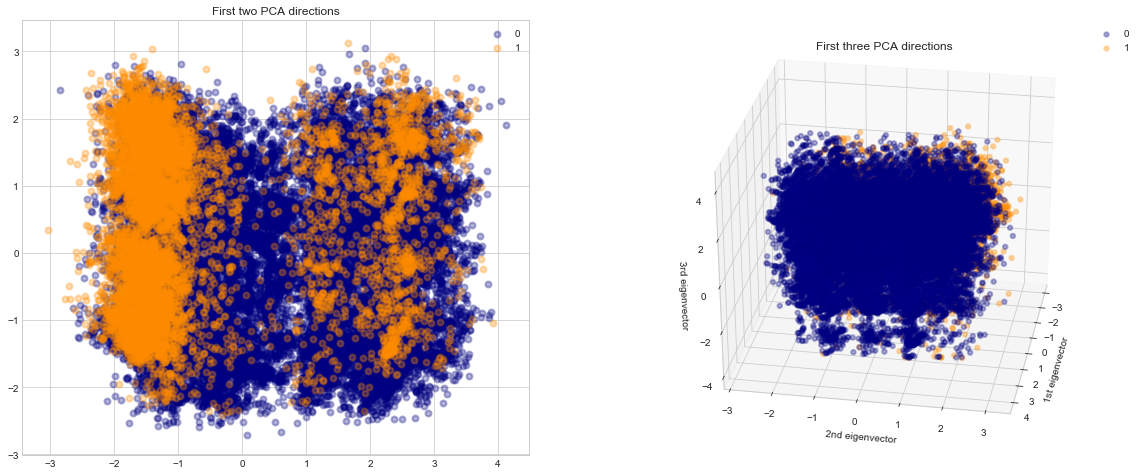

In [54]:
# PCA元素的二维、三维显示
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
y = dataset_con_enc['predclass']

# 格式
target_names = [0,1]
colors = ['navy','darkorange']
lw = 2
alpha = 0.3
# 2个最优属性
plt.style.use('seaborn-whitegrid')
plt.figure(2, figsize=(20, 8))

plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], 
                color=color, 
                alpha=alpha, 
                lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First two PCA directions');

# 3个最优属性
ax = plt.subplot(1, 2, 2, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2], 
               color=color,
               alpha=alpha,
               lw=lw, 
               label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# 三维旋转
ax.view_init(30, 10)

## 选择你要的数据集

我们现在有两个数据集可供选择以应用我们的ML算法。 one-hot-encoded和label-encoded。 （以下不进行特征选择）

In [55]:
# 可选的数据集: 
# - dataset_bin_enc（离散编码后）
# - dataset_con_enc（连续编码后）

# 都进行机器学习，最后对比效果

# selected_dataset = dataset_con_enc
selected_dataset =  dataset_bin_enc

In [56]:
selected_dataset.head(2)

,predclass,"age_(16.927, 24.3]","age_(24.3, 31.6]","age_(31.6, 38.9]","age_(38.9, 46.2]","age_(46.2, 53.5]","age_(53.5, 60.8]","age_(60.8, 68.1]","age_(68.1, 75.4]","age_(75.4, 82.7]",...,sex-marital_FemaleMarried,sex-marital_FemaleNever-Married,sex-marital_FemaleNot-Married,sex-marital_FemaleSeparated,sex-marital_FemaleWidowed,sex-marital_MaleMarried,sex-marital_MaleNever-Married,sex-marital_MaleNot-Married,sex-marital_MaleSeparated,sex-marital_MaleWidowed
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## 划分 训练集 & 测试集

因为~我们一开始合并了

In [57]:
# 拆分训练集和测试集
train = selected_dataset.loc[0:32560,:]
test = selected_dataset.loc[32560:,:]

### 去除缺失值

In [58]:
# 适用（缺失值数目比较少） -->如果多了呢？
train = train.dropna(axis=0)
test = test.dropna(axis=0)

### 算法开始之前重命名属性和目标

In [59]:
X_train_w_label = train
X_train = train.drop(['predclass'], axis=1)
y_train = train['predclass'].astype('int64')
X_test  = test.drop(['predclass'], axis=1)
y_test  = test['predclass'].astype('int64')

## 现在，选择算法！

### 先...看下数据长啥样

In [60]:
X_train.shape

(32561, 115)

In [61]:
X_train.head()

,"age_(16.927, 24.3]","age_(24.3, 31.6]","age_(31.6, 38.9]","age_(38.9, 46.2]","age_(46.2, 53.5]","age_(53.5, 60.8]","age_(60.8, 68.1]","age_(68.1, 75.4]","age_(75.4, 82.7]","age_(82.7, 90.0]",...,sex-marital_FemaleMarried,sex-marital_FemaleNever-Married,sex-marital_FemaleNot-Married,sex-marital_FemaleSeparated,sex-marital_FemaleWidowed,sex-marital_MaleMarried,sex-marital_MaleNever-Married,sex-marital_MaleNot-Married,sex-marital_MaleSeparated,sex-marital_MaleWidowed
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [62]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: predclass, dtype: int64

In [63]:
# 设置随机种子将保证我们每次行训练和测试都得到相同的结果
random.seed(1) # 记住这个数字

### 选择算法

以下是用到的算法.

- KNN
- Logistic Regression
- Random Forest
- Naive Bayes
- Linear SVC
- Decision Tree
- Gradient Boosted Trees


In [64]:
# 绘制ROC曲线
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [99]:
# 训练模型，并输出预测结果
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    # 训练
    model = algo.fit(X_train, y_train)
    # 预测
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier,
                          XGBClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # 交叉验证
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1) # 所有CPU核
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

In [66]:
# 逻辑回归（随机选择最优参数）

# 输出最佳参数的统一方法
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# 设置参数
param_dist = {'penalty': ['l2', 'l1'], 
              'class_weight': [None, 'balanced'],
              'C': np.logspace(-20, 20, 10000), 
              'intercept_scaling': np.logspace(-20, 20, 10000)}

# 随机选取参数
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 9.09 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.800 (std: 0.004)
Parameters: {'penalty': 'l1', 'intercept_scaling': 1.615923668351611e-16, 'class_weight': 'balanced', 'C': 59618018539476.11}

Model with rank: 2
Mean validation score: 0.800 (std: 0.004)
Parameters: {'penalty': 'l1', 'intercept_scaling': 117.54577418803332, 'class_weight': 'balanced', 'C': 1122.8067905278133}

Model with rank: 2
Mean validation score: 0.800 (std: 0.004)
Parameters: {'penalty': 'l1', 'intercept_scaling': 82.07132012393893, 'class_weight': 'balanced', 'C': 3014726543750.2964}

Model with rank: 4
Mean validation score: 0.792 (std: 0.001)
Parameters: {'penalty': 'l1', 'intercept_scaling': 2.610608057876622e-13, 'class_weight': 'balanced', 'C': 0.015339760600349988}

Model with rank: 5
Mean validation score: 0.759 (std: 0.000)
Parameters: {'penalty': 'l2', 'intercept_scaling': 2.7286233694994084e+19, 'class_weight': 'balanced', 'C': 611897

In [67]:
# 训练
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 84.46
Accuracy CV 10-Fold: 84.32
Running Time: 0:00:07.187826


             precision    recall  f1-score   support

          0       0.88      0.93      0.90     24720
          1       0.71      0.58      0.64      7841

avg / total       0.84      0.84      0.84     32561

             precision    recall  f1-score   support

          0       0.88      0.92      0.90     12435
          1       0.71      0.59      0.64      3847

avg / total       0.84      0.84      0.84     16282



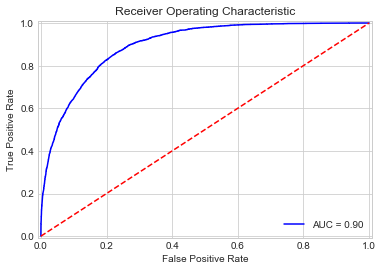

In [68]:
print(metrics.classification_report(y_train, train_pred_log) )
print( metrics.classification_report(y_test, test_pred_log) )
plot_roc_curve(y_test, probs_log)

In [69]:
# KNN
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1), 
                                                                                                 X_train, 
                                                                                                 y_train, 
                                                                                                 X_test, 
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 81.02
Accuracy CV 10-Fold: 81.13
Running Time: 0:02:29.936422


             precision    recall  f1-score   support

          0       0.86      0.89      0.88     24720
          1       0.62      0.56      0.59      7841

avg / total       0.81      0.81      0.81     32561

             precision    recall  f1-score   support

          0       0.87      0.89      0.88     12435
          1       0.61      0.56      0.58      3847

avg / total       0.81      0.81      0.81     16282



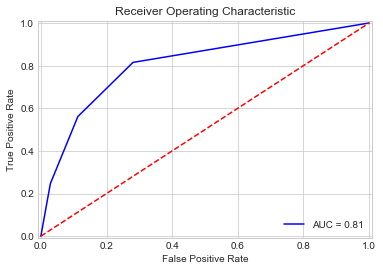

In [70]:
print (metrics.classification_report(y_train, train_pred_knn) )
print (metrics.classification_report(y_test, test_pred_knn) )
plot_roc_curve(y_test, probs_knn)

In [71]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau = fit_ml_algo(GaussianNB(), 
                                                                                     X_train, 
                                                                                     y_train, 
                                                                                     X_test, 
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 75.59
Accuracy CV 10-Fold: 74.51
Running Time: 0:00:06.009974


             precision    recall  f1-score   support

          0       0.95      0.70      0.81     24720
          1       0.48      0.88      0.62      7841

avg / total       0.84      0.75      0.76     32561

             precision    recall  f1-score   support

          0       0.94      0.72      0.82     12435
          1       0.49      0.86      0.63      3847

avg / total       0.84      0.76      0.77     16282



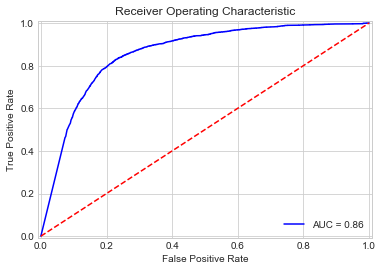

In [72]:
print (metrics.classification_report(y_train, train_pred_gaussian) )
print( metrics.classification_report(y_test, test_pred_gaussian) )
plot_roc_curve(y_test, probs_gau)

In [92]:
# Linear SVC
start_time = time.time()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(LinearSVC(),
                                                                                           X_train, 
                                                                                           y_train,
                                                                                           X_test, 
                                                                                           10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 84.42
Accuracy CV 10-Fold: 84.46
Running Time: 0:00:11.565789


             precision    recall  f1-score   support

          0       0.95      0.70      0.81     24720
          1       0.48      0.88      0.62      7841

avg / total       0.84      0.75      0.76     32561

             precision    recall  f1-score   support

          0       0.94      0.72      0.82     12435
          1       0.49      0.86      0.63      3847

avg / total       0.84      0.76      0.77     16282



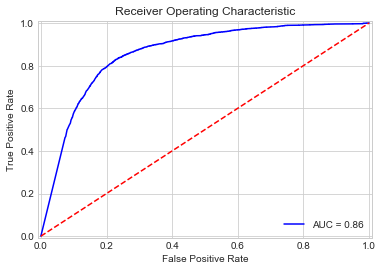

In [94]:
print (metrics.classification_report(y_train, train_pred_gaussian) )
print( metrics.classification_report(y_test, test_pred_gaussian) )
plot_roc_curve(y_test, probs_gau)

In [75]:
# 决策树
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 79.97
Accuracy CV 10-Fold: 80.31
Running Time: 0:00:06.801822


             precision    recall  f1-score   support

          0       0.86      0.89      0.87     24720
          1       0.60      0.54      0.57      7841

avg / total       0.80      0.80      0.80     32561

             precision    recall  f1-score   support

          0       0.86      0.88      0.87     12435
          1       0.58      0.53      0.56      3847

avg / total       0.79      0.80      0.80     16282



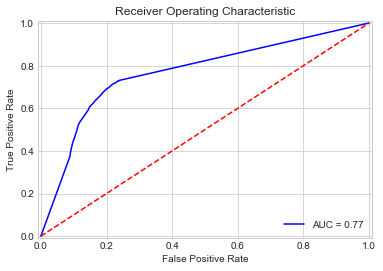

In [76]:
print (metrics.classification_report(y_train, train_pred_dt) )
print (metrics.classification_report(y_test, test_pred_dt) )
plot_roc_curve(y_test, probs_dt)

In [77]:
# 随机森林

# 输出参数得分
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# 设置参数范围
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# 随机搜索
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 8.26 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.838 (std: 0.004)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 2, 'min_samples_split': 9}

Model with rank: 2
Mean validation score: 0.837 (std: 0.003)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 9}

Model with rank: 3
Mean validation score: 0.835 (std: 0.004)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 10}

Model with rank: 4
Mean validation score: 0.834 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 11}

Model with rank: 5
Mean validation score: 0.834 (std: 0.005)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'm

In [78]:
# 训练
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 83.96
Accuracy CV 10-Fold: 84.04
Running Time: 0:00:06.926943


             precision    recall  f1-score   support

          0       0.87      0.93      0.90     24720
          1       0.71      0.57      0.63      7841

avg / total       0.83      0.84      0.83     32561

             precision    recall  f1-score   support

          0       0.87      0.93      0.90     12435
          1       0.70      0.56      0.62      3847

avg / total       0.83      0.84      0.83     16282



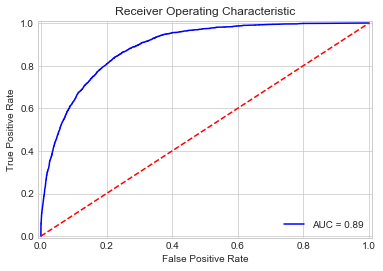

In [79]:
print(metrics.classification_report(y_train, train_pred_rf) )
print( metrics.classification_report(y_test, test_pred_rf) )
plot_roc_curve(y_test, probs_rf)

In [103]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 84.52
Accuracy CV 10-Fold: 84.35
Running Time: 0:00:43.199724


             precision    recall  f1-score   support

          0       0.87      0.93      0.90     24720
          1       0.72      0.57      0.64      7841

avg / total       0.84      0.84      0.84     32561

             precision    recall  f1-score   support

          0       0.88      0.93      0.90     12435
          1       0.71      0.58      0.64      3847

avg / total       0.84      0.85      0.84     16282



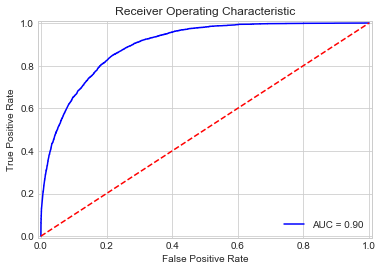

In [104]:
print(metrics.classification_report(y_train, train_pred_gbt) )
print( metrics.classification_report(y_test, test_pred_gbt) )
plot_roc_curve(y_test, probs_gbt)

In [112]:
clf = XGBClassifier()
# # 模型训练
clf.fit(X_train, y_train)
# 模型对测试集进行预测
y_pre_trarin = clf.predict(X_train)   # 预测值
# y_pre_test= clf.predict(X_test)
# y_prb_1 = clf.predict_proba(X_train)[:, 1]  # 预测为1的概率

print("full_scene  AUC Score  %f" % metrics.roc_auc_score(y_train, y_pre_trarin))

print("full_scene  \n",metrics.classification_report(y_train, y_pre_trarin) )


full_scene  AUC Score  0.752224
full_scene  
              precision    recall  f1-score   support

          0       0.87      0.93      0.90     24720
          1       0.72      0.57      0.64      7841

avg / total       0.84      0.84      0.84     32561



In [ ]:
print(metrics.classification_report(y_train, train_pred_gbt) )
print( metrics.classification_report(y_test, test_pred_gbt) )
plot_roc_curve(y_test, probs_gbt)

## 效果对比

In [82]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
             'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_knn, 
        acc_log, 
        acc_rf, 
        acc_gaussian,  
        acc_linear_svc, 
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
6,Gradient Boosting Trees,84.52
1,Logistic Regression,84.46
4,Linear SVC,84.42
2,Random Forest,83.96
0,KNN,81.02
5,Decision Tree,79.97
3,Naive Bayes,75.59


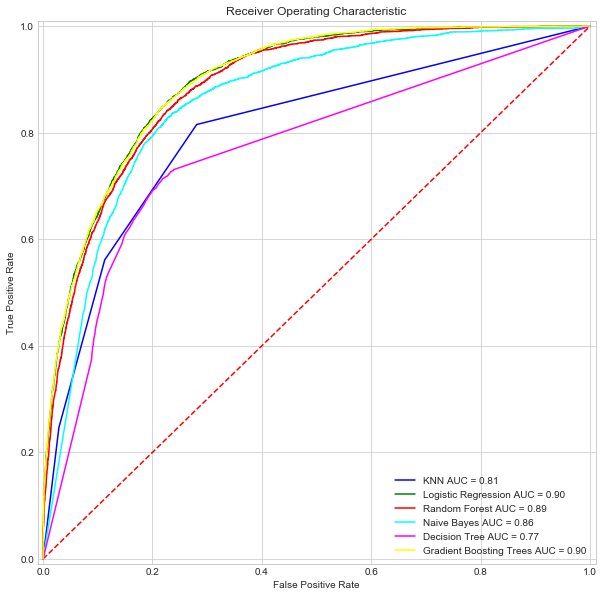

In [84]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10)) 

models = [
    'KNN', 
    'Logistic Regression', 
    'Random Forest', 
    'Naive Bayes', 
    'Decision Tree', 
    'Gradient Boosting Trees'
]
probs = [
    probs_knn,
    probs_log,
    probs_rf,
    probs_gau,
    probs_dt,
    probs_gbt
]
colors = [
    'blue',
    'green',
    'red',
    'cyan',
    'magenta',
    'yellow',
]
    
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
    plt.legend(loc = 'lower right')
    
for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])
    
plt.show()